* **`thread_id` is the key driver of short-term (thread-scoped) memory** in LangGraph—it binds the persistent state and checkpoints of a specific conversational flow. If you reuse the same `thread_id`, all prior context remains active, regardless of the `user_id` ([langchain-ai.github.io][1]).
* **`user_id` governs long-term memory**, stored separately in a Store (e.g., `InMemoryStore`, PostgresStore), and is shared across different threads. It **does not affect thread-scoped memory** .
* **To isolate conversations**, always use a fresh `thread_id` for each session; changing only `user_id` won’t clear the conversation’s history.

[1]: https://langchain-ai.github.io/langgraph/concepts/persistence/?utm_source=chatgpt.com "LangGraph Persistence - Overview"


# Loading env Variables

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from a .env file

# Access API keys and credentials
OPENAI_API_KEY    = os.environ["OPENAI_API_KEY"]
TIMESCALE_DB_URI  = os.environ["TIMESCALE_DB_URI"]
TAVILY_API_KEY    = os.environ["TAVILY_API_KEY"]
LANGCHAIN_API_KEY = os.environ["LANGCHAIN_API_KEY"] 
MAIN_AGENT_DB_URI = os.environ["MAIN_AGENT_DB_URI"]

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"]    = "langchain-academy"


# Defining the agent

In [ ]:
# # -------------------------
# # IMPORTS
# # -------------------------

# from IPython.display import Image, display
# from langgraph.graph import StateGraph, MessagesState, START, END
# from langchain_core.messages import HumanMessage, SystemMessage

# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.store.memory import InMemoryStore
# from langchain_core.runnables.config import RunnableConfig
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.store.base import BaseStore

# from pydantic import BaseModel, Field
# from trustcall import create_extractor

# from langchain_core.documents import Document
# from langchain_core.messages import merge_message_runs

# import uuid
# from langchain_core.messages import HumanMessage, AIMessage
# from langchain_openai import ChatOpenAI

# from psycopg_pool import ConnectionPool
# from langgraph.checkpoint.postgres import PostgresSaver

# from typing import Optional, TypedDict, Literal
# from datetime import datetime


# # -------------------------
# # DATABASE SETUP
# # -------------------------

# # Connection settings for PostgreSQL (used for cross-thread memory)
# connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# # Initialize a persistent connection pool for efficient DB access
# pool = ConnectionPool(conninfo=MAIN_AGENT_DB_URI, max_size=20, kwargs=connection_kwargs)

# # Create a Postgres-backed checkpointer to persist state
# checkpointer = PostgresSaver(pool)
# checkpointer.setup()  # Ensures that the necessary tables are created


# # -------------------------
# # GRAPH STATE SCHEMA
# # -------------------------

# class GraphState(MessagesState):
#     """Defines the main data structure used for graph state management."""
#     question:            str
#     documents:           list[Document]
#     candidate_answer:    str
#     retries:             int
#     web_fallback:        bool
#     scrag_tool_call_id:  str


# # -------------------------
# # MODEL SETUP
# # -------------------------

# # Initialize OpenAI's GPT model
# model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)

# # In-memory store for within-thread memory (temporary and session-limited)
# across_thread_memory = InMemoryStore()


# # -------------------------
# # SYSTEM PROMPT FOR MODEL
# # -------------------------

# MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

# You have a long-term memory which stores general user information.

# <user_profile>
# {user_profile}
# </user_profile>

# Instructions:

# 1. Analyze the user's message carefully.

# 2. If personal information is present, update the user profile via `Routing_Decision` with `update_type='prof'`.

# 3. Do not inform the user if you updated the profile unless they explicitly ask for it.

# 4. If the user's name is known, use it directly without updating the profile.

# 5. For calculations, call `Routing_Decision` with `update_type='calc'`.

# 6. For scientific queries, invoke `Routing_Decision` with `update_type='rag'`.

# 7. After the RAG tool's message, just reply: "I hope this answers your question."

# 8. Verify each calculation by calling `Routing_Decision` with `update_type='calc'`. Perform all steps by calling the calc tool.
# """


# class Routing_Decision(TypedDict):
#     """Specifies the type of action the assistant should take."""
#     update_type: Literal['prof', 'calc', 'rag']


# # -------------------------
# # FUNCTION: Call model
# # -------------------------

# def call_model(state: GraphState, config: RunnableConfig, store: BaseStore):
#     """
#     Loads the user's long-term memory from the store and generates a personalized response 
#     using the system prompt and conversation history.
#     """
#     user_id = config["configurable"]["user_id"]
#     namespace = ("profile", user_id)

#     # Retrieve existing long-term memory records from the database
#     with SessionLocal() as db:
#         user_records = db.query(LTM_Table_Skeleton).filter(LTM_Table_Skeleton.user_id == user_id).all() ######################################################

#     # Set and store retrieved memory (if any)
#     current_user_record = None if len(user_records) == 0 else user_records[0]
#     if current_user_record:
#         store.put(namespace=namespace, key=current_user_record.memory_key, value=current_user_record.memory_value)

#     # Search the memory store for user profile data
#     memories = store.search(namespace)
#     user_profile = memories[0].value if memories else None

#     # Format and invoke the model
#     system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile)
#     response = model.bind_tools([Routing_Decision], parallel_tool_calls=False).invoke(
#         [SystemMessage(content=system_msg)] + state["messages"]
#     )
#     return {'messages': [response]}


# # -------------------------
# # FUNCTION: Perform calculations
# # -------------------------

# def calculations(state: GraphState, config: RunnableConfig, store: BaseStore):
#     """
#     Invokes the appropriate calculator tool and returns the formatted result.
#     """
#     response = model.bind_tools([arithmetic_calculator], parallel_tool_calls=False).invoke(state["messages"][:-1])
#     args = response.tool_calls[0]['args']
#     result = arithmetic_calculator(args['n1'], args['n2'], args['ops'])
#     content = f"{args['n1']} {args['ops']} {args['n2']} = {result}"

#     tool_calls = state['messages'][-1].tool_calls
#     return {"messages": [{"role": "tool", "content": content, "tool_call_id": tool_calls[0]['id']}]}


# # -------------------------
# # FUNCTION: Pass message to RAG agent
# # -------------------------

# def interim_rag_node(state: GraphState, config: RunnableConfig, store: BaseStore):
#     """
#     Forwards the request to the self-corrective RAG agent.
#     """
#     tool_calls = state['messages'][-1].tool_calls
#     return {"messages": [{"role": "tool", "content": "Passed on the request to self_corrective_rag_agent subgraph", "tool_call_id": tool_calls[0]['id']}]}


# # -------------------------
# # USER PROFILE MODEL
# # -------------------------

# class Profile(BaseModel):
#     """Represents structured user profile information."""
#     name:        Optional[str]  = Field(description="User's name",                                              default=None)
#     bachelor:    Optional[str]  = Field(description="Bachelor's degree subject",                                default=None)
#     master:      Optional[str]  = Field(description="Master's degree subject",                                  default=None)
#     phd:         Optional[str]  = Field(description="PhD subject",                                              default=None)
#     connections: list[str]      = Field(description="User's personal connections (friends, family, coworkers)", default_factory=list)
#     interests:   list[str]      = Field(description="User's interests",                                         default_factory=list)


# # -------------------------
# # TRUSTCALL EXTRACTOR SETUP
# # -------------------------

# # Create a Trustcall extractor to update the user profile
# profile_extractor = create_extractor(
#     model,
#     tools=[Profile],
#     tool_choice="Profile",
# )

# # Instruction to guide Trustcall memory extraction
# TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

# Use the provided tools to retain any necessary memories about the user. Specifically, extract the subject in which the user earned their bachelor's degree.

# Use parallel tool calling to handle updates and insertions simultaneously.

# System Time: {time}"""


# # -------------------------
# # FUNCTION: Update user profile
# # -------------------------

# def update_profile(state: GraphState, config: RunnableConfig, store: BaseStore):
#     """
#     Uses the Trustcall extractor to analyze chat history and update the user's long-term memory.
#     """
#     user_id = config["configurable"]["user_id"]
#     namespace = ("profile", user_id)

#     # Retrieve current user record (if any) and load it into the memory store
#     with SessionLocal() as db:
#         user_records = db.query(LTM_Table_Skeleton).filter(LTM_Table_Skeleton.user_id == user_id).all() ###############################################

#     current_user_record = None if len(user_records) == 0 else user_records[0]
#     if current_user_record:
#         store.put(namespace=namespace, key=current_user_record.memory_key, value=current_user_record.memory_value)

#     # Prepare existing memory for the extractor
#     existing_items = store.search(namespace)
#     existing_memories = [(item.key, "Profile", item.value) for item in existing_items] if existing_items else None

#     # Merge messages and format instruction
#     updated_messages = list(merge_message_runs(messages=[
#         SystemMessage(content=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat()))
#     ] + state["messages"][:-1]))

#     # Run the extractor
#     result = profile_extractor.invoke({"messages": updated_messages, "existing": existing_memories})

#     # Store updated memories
#     for r, rmeta in zip(result["responses"], result["response_metadata"]):
#         store.put(namespace, rmeta.get("json_doc_id", str(uuid.uuid4())), r.model_dump(mode="json"))

#     # Persist the memory to the database
#     current_pydantic_ltm = langgraph_ltm_to_pydantic_ltm(store.search(namespace)[0])
#     with SessionLocal() as db:
#         replace_ltm_in_db(current_pydantic_ltm, db)

#     tool_calls = state['messages'][-1].tool_calls
#     return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id": tool_calls[0]['id']}]}


# # -------------------------
# # FUNCTION: Routing logic
# # -------------------------

# def route_message(state: GraphState, config: RunnableConfig, store: BaseStore) -> Literal['calculations', 'update_profile', 'self_corrective_rag_agent', END]:
#     """
#     Determines the next action based on tool call arguments:
#     - Profile update
#     - Calculation
#     - RAG query
#     """
#     message = state['messages'][-1]
#     if len(message.tool_calls) == 0:
#         return END

#     tool_call = message.tool_calls[0]
#     action = tool_call['args']['update_type']

#     if action == "prof":
#         return "update_profile"
#     elif action == "calc":
#         return "calculations"
#     elif action == "rag":
#         return "interim_rag_node"
#     else:
#         raise ValueError(f"Unexpected update_type: {action}")




In [1]:
# 1) Make sure the .env from the repo root is loaded into the current process
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(".env", usecwd=True))  # searches upward from CWD

import os
assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY not found after loading .env"

# 2) Ensure the project 'src' is on sys.path
import sys, os
sys.path.insert(0, os.path.abspath(".."))  # now 'src' is on path

# # --- Option A: import via the package (may import other agents too)
# from agents.interrupt_agent import interrupt_agent


In [4]:
# from psycopg_pool import ConnectionPool
# from langgraph.checkpoint.postgres import PostgresSaver

# # -------------------------
# # DATABASE SETUP
# # -------------------------

# # Connection settings for PostgreSQL (used for cross-thread memory)
# connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# # Initialize a persistent connection pool for efficient DB access
# pool = ConnectionPool(conninfo=MAIN_AGENT_DB_URI, max_size=20, kwargs=connection_kwargs)

# # Create a Postgres-backed checkpointer to persist state
# checkpointer = PostgresSaver(pool)
# checkpointer.setup()  # Ensures that the necessary tables are created

In [29]:
# -------------------------
# MODEL SETUP
# -------------------------
from langchain_openai import ChatOpenAI

# Initialize OpenAI's GPT model
model = ChatOpenAI(model="gpt-5-nano-2025-08-07", reasoning_effort='low', streaming=True, model_kwargs={"text": {"verbosity": "low"}})


In [3]:
model.invoke(input='2+2 ?')

AIMessage(content='4', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-5-nano-2025-08-07', 'service_tier': 'default'}, id='run--b420cf73-ba3b-4dd4-ae2f-9696a8e03394-0')

In [4]:
# -------------------------
# MODEL SETUP
# -------------------------
from langchain_openai import ChatOpenAI

# Initialize OpenAI's GPT model
model = ChatOpenAI(model="gpt-5-nano-2025-08-07", reasoning_effort='low', streaming=True)


In [5]:
model.invoke(input='2+2 ?')

AIMessage(content='4', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-5-nano-2025-08-07', 'service_tier': 'default'}, id='run--d114832f-5ed3-4bf6-9bc3-83d1c3fa8eb9-0')

In [19]:
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langgraph.graph import StateGraph, MessagesState, START, END

MODEL_SYSTEM_MESSAGE = """ You are a helpful chatbot on the website of an accounting firm.
Your role is to provide users with accurate information about the firm’s services.
The details of services provided by the accounting firm are as follows:

<accounting_services>
{accounting_services}
</accounting_services>
"""

accounting_services = 'null'

# Note: it's wrong if:
# def call_model(state: StateGraph .
# if u want to do that then first define 'StateGraph', fully like i did in the multi_agent_system, otherwise it won't work ...

async def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Format and invoke the model
    system_msg = MODEL_SYSTEM_MESSAGE.format(accounting_services=accounting_services)
    response   = await model.ainvoke(
        input  = [SystemMessage(content=system_msg)] + state["messages"],
        config = config
    )
    return {'messages': [response]}




In [20]:
# -------------------------
# BUILD THE GRAPH
# -------------------------


from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage


#builder = StateGraph(GraphState)
builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)
#builder.add_node("interim_rag_node", interim_rag_node)
#builder.add_node("self_corrective_rag_agent", Self_Corrective_RAG_Agent.compile())

builder.add_edge(START, "call_model")
#builder.add_edge("interim_rag_node", "self_corrective_rag_agent")
#builder.add_edge("self_corrective_rag_agent", END)
#builder.add_conditional_edges('call_model', route_message, ["interim_rag_node", END])
builder.add_edge('call_model', END)


# Compile the graph with persistent checkpointer and in-memory store
graph = builder.compile()#checkpointer=memory, store=across_thread_memory) #checkpointer



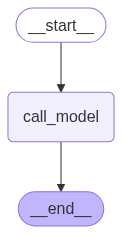

In [21]:
# View
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph().draw_ascii(), '\n\n')
    print(graph.get_graph().draw_mermaid())
# https://mermaid.live/edit#pako:eNp1Ul2PmzAQ_CvWVlESCSjfSXynvFx-Qp9aTsgHdrBqbGTMtVfEf6-BHHdU6duOZ3Zn1nYPhSopYNhsei65wajfMqF-FRXRZjuiotOv1FZbwSUlejsMw2aTyasmTYW-XR4ymZk8b43V5_nux2NzXtDj1-b8vMcYM65bMwoLIkReW0ex-yj3N6boBDFcyXb3GUxs15TE0LzRinFBd2u4nyNQWS4BpnqxF2R2X4Ih1z2jjwAP_wa4x689_zPhBpHrzfQy8a5gPfKu5LbKzNk92gtlqKSMdMIg2yXwFxYynzFnfB63ovxaGRx44aphuv9J7qqGFNy8YX8lGG_oNu6FvaSsAAeumpeAje6oAzXVNRkh9JlEKANT0ZpmgG1ZEv0zg0wOtqch8rtS9XubVt21AsyIaC2a171wYv9OvZxquyDVT6qTBnB68qchgHv4DThIDp4fB2kchFESJUGSOvBmj1PvEPtRcAxPxyg6HeN4cODP5Ot7aRBExzSOQj9K0jA5DH8BLyP9pw


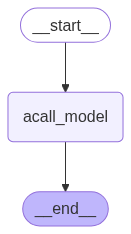

In [4]:
from langgraph.graph import END, MessagesState, StateGraph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from core import get_model, settings


class AgentState(MessagesState, total=False):
    """`total=False` marks fields added here as optional (PEP 589),
    while inherited fields (like `messages` from MessagesState) keep their original requirements.

    documentation: https://typing.readthedocs.io/en/latest/spec/typeddict.html#totality
    """
    # # Safety metadata from LlamaGuard (populated by guard nodes)
    # safety: LlamaGuardOutput

    # # LangGraph-managed remaining step budget for the current run
    # remaining_steps: RemainingSteps


MODEL_SYSTEM_MESSAGE = """ You are a helpful chatbot on the website of an accounting firm.
Your role is to provide users with accurate information about the firm’s services.
The details of services provided by the accounting firm are as follows:

<accounting_services>
{accounting_services}
</accounting_services>
"""

accounting_services = 'null'


async def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    """Main model node:
       - Selects the concrete model (from config or default),
       - Runs the tool-enabled chat model,
       - Post-checks the output with LlamaGuard,
       - Enforces step budget if tool calls remain."""
    
    model      = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))
    system_msg = MODEL_SYSTEM_MESSAGE.format(accounting_services=accounting_services)
    response   = await model.ainvoke(
        [SystemMessage(content=system_msg)] + state["messages"],
        config=config
    )
    
    return {"messages": [response]}



# -------------------------
# BUILD THE GRAPH
# -------------------------


from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage


builder = StateGraph(AgentState)

builder.add_node("acall_model", acall_model)

builder.set_entry_point("acall_model")
builder.add_edge('acall_model', END)


# Compile the graph with persistent checkpointer and in-memory store
graph = builder.compile()#checkpointer=memory, store=across_thread_memory) #checkpointer



# View
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph().draw_ascii(), '\n\n')
    print(graph.get_graph().draw_mermaid())
# https://mermaid.live/edit#pako:eNp1Ul2PmzAQ_CvWVlESCSjfSXynvFx-Qp9aTsgHdrBqbGTMtVfEf6-BHHdU6duOZ3Zn1nYPhSopYNhsei65wajfMqF-FRXRZjuiotOv1FZbwSUlejsMw2aTyasmTYW-XR4ymZk8b43V5_nux2NzXtDj1-b8vMcYM65bMwoLIkReW0ex-yj3N6boBDFcyXb3GUxs15TE0LzRinFBd2u4nyNQWS4BpnqxF2R2X4Ih1z2jjwAP_wa4x689_zPhBpHrzfQy8a5gPfKu5LbKzNk92gtlqKSMdMIg2yXwFxYynzFnfB63ovxaGRx44aphuv9J7qqGFNy8YX8lGG_oNu6FvaSsAAeumpeAje6oAzXVNRkh9JlEKANT0ZpmgG1ZEv0zg0wOtqch8rtS9XubVt21AsyIaC2a171wYv9OvZxquyDVT6qTBnB68qchgHv4DThIDp4fB2kchFESJUGSOvBmj1PvEPtRcAxPxyg6HeN4cODP5Ot7aRBExzSOQj9K0jA5DH8BLyP9pw











    

In [5]:
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import HumanMessage

from core import settings

store  = InMemoryStore()
config = {"configurable": {"thread_id": "1", "user_id": "1"}}
input_messages = [HumanMessage(content="My name is Ans? what's your name?")] # "What was my name?"

async with AsyncSqliteSaver.from_conn_string(settings.SQLITE_DB_PATH) as checkpointer:
    # attach the *opened* saver and store
    graph.checkpointer = checkpointer
    graph.store = store

    async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="messages"):
        print(chunk[0].content, sep=' ', end='')


Nice to meet you, Ans. I’m the accounting firm’s virtual assistant. How can I help you today—questions about our services, or would you like to be connected with a team member? If you’d prefer I use a different name or spelling, just tell me.

In [6]:
input_messages = [HumanMessage(content="A 200 words essay on accounting")]

async with AsyncSqliteSaver.from_conn_string(settings.SQLITE_DB_PATH) as checkpointer:
    # attach the *opened* saver and store
    graph.checkpointer = checkpointer
    graph.store = store

    async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="messages"):
        print(chunk[0].content, sep=' ', end='')


Accounting is the language of business, translating financial activity into meaningful information that guides decisions. It begins with the systematic recording of every transaction, ensuring that each debit has a corresponding credit and that financial history is preserved with accuracy. From these records, accountants classify and summarize data into financial statements that reflect a company’s performance, position, and cash flow.

Key statements—the balance sheet, income statement, and cash flow statement—provide a comprehensive snapshot: what the business owns, what it owes, how it earns money, and how it deploys cash. These reports enable managers to evaluate profitability, liquidity, and solvency, and they offer essential insights to investors, lenders, and regulators. Beyond reporting, accounting supports planning and control. Budgets, forecasts, and variance analyses translate past results into future expectations, guiding resource allocation and strategic priorities.

Ethic

In [14]:
input_messages = [HumanMessage(content="What was my name?")]

async with AsyncSqliteSaver.from_conn_string(settings.SQLITE_DB_PATH) as checkpointer:
    # attach the *opened* saver and store
    graph.checkpointer = checkpointer
    graph.store = store

    async for chunk in graph.astream({"messages": input_messages}, config, stream_mode="values"):
        chunk["messages"][-1].pretty_print()


================================ Human Message =================================

What was my name?
================================== Ai Message ==================================

Your name is Ans. If you’d like me to use a different name or spelling, just let me know. How can I help you with accounting today?


In [6]:
import os

file_path = "./checkpoints.db"  # adjust if it's in another folder

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} deleted.")
else:
    print(f"{file_path} not found.")


./checkpoints.db deleted.


In [12]:
# # We supply a thread ID for short-term (within-thread) memory
# # We supply a user ID for long-term (across-thread) memory 
# config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# # User input to create a profile memory
# input_messages = [HumanMessage(content="My name is Ans? what's your name?")]

# # Run the graph
# for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()


================================ Human Message =================================

My name is Ans? what's your name?
================================== Ai Message ==================================

Hello, Ans! I’m here to assist you with information about our accounting services. How can I help you today?


In [13]:
# # User input to create a profile memory
# input_messages = [HumanMessage(content="What was my name?")]

# # Run the graph
# for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()


================================ Human Message =================================

What was my name?
================================== Ai Message ==================================

Your name is Ans. How can I assist you further today?


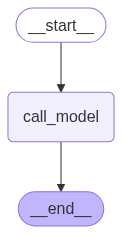

================================ Human Message =================================

What was my last question to you?
================================== Ai Message ==================================

Your last question was, "Hi do u remember my name?" How can I assist you further today?


In [10]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from a .env file

# Access API keys and credentials
OPENAI_API_KEY    = os.environ["OPENAI_API_KEY"]
TIMESCALE_DB_URI  = os.environ["TIMESCALE_DB_URI"]
TAVILY_API_KEY    = os.environ["TAVILY_API_KEY"]
LANGCHAIN_API_KEY = os.environ["LANGCHAIN_API_KEY"] 
MAIN_AGENT_DB_URI = os.environ["MAIN_AGENT_DB_URI"]

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"]    = "langchain-academy"


from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver

# -------------------------
# DATABASE SETUP
# -------------------------

# Connection settings for PostgreSQL (used for cross-thread memory)
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# Initialize a persistent connection pool for efficient DB access
pool = ConnectionPool(conninfo=MAIN_AGENT_DB_URI, max_size=20, kwargs=connection_kwargs)

# Create a Postgres-backed checkpointer to persist state
checkpointer = PostgresSaver(pool)
checkpointer.setup()  # Ensures that the necessary tables are created


# -------------------------
# MODEL SETUP
# -------------------------
from langchain_openai import ChatOpenAI

# Initialize OpenAI's GPT model
model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)


from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langgraph.graph import StateGraph, MessagesState, START, END

MODEL_SYSTEM_MESSAGE = """ You are a helpful chatbot on the website of an accounting firm.
Your role is to provide users with accurate information about the firm’s services.
The details of services provided by the accounting firm are as follows:

<accounting_services>
{accounting_services}
</accounting_services>
"""

accounting_services = 'null'

# Note: it's wrong if:
# def call_model(state: StateGraph .
# if u want to do that then first define 'StateGraph', fully like i did in the multi_agent_system, otherwise it won't work ...

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    # Format and invoke the model
    system_msg = MODEL_SYSTEM_MESSAGE.format(accounting_services=accounting_services)
    response   = model.invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )
    return {'messages': [response]}



# -------------------------
# BUILD THE GRAPH
# -------------------------


from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage


builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)

builder.add_edge(START, "call_model")
builder.add_edge('call_model', END)

# Compile the graph with persistent checkpointer and in-memory store
graph = builder.compile(checkpointer=checkpointer)#checkpointer=memory, store=across_thread_memory) #checkpointer


# View
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph().draw_ascii(), '\n\n')
    print(graph.get_graph().draw_mermaid())
# https://mermaid.live/edit#pako:eNp1Ul2PmzAQ_CvWVlESCSjfSXynvFx-Qp9aTsgHdrBqbGTMtVfEf6-BHHdU6duOZ3Zn1nYPhSopYNhsei65wajfMqF-FRXRZjuiotOv1FZbwSUlejsMw2aTyasmTYW-XR4ymZk8b43V5_nux2NzXtDj1-b8vMcYM65bMwoLIkReW0ex-yj3N6boBDFcyXb3GUxs15TE0LzRinFBd2u4nyNQWS4BpnqxF2R2X4Ih1z2jjwAP_wa4x689_zPhBpHrzfQy8a5gPfKu5LbKzNk92gtlqKSMdMIg2yXwFxYynzFnfB63ovxaGRx44aphuv9J7qqGFNy8YX8lGG_oNu6FvaSsAAeumpeAje6oAzXVNRkh9JlEKANT0ZpmgG1ZEv0zg0wOtqch8rtS9XubVt21AsyIaC2a171wYv9OvZxquyDVT6qTBnB68qchgHv4DThIDp4fB2kchFESJUGSOvBmj1PvEPtRcAxPxyg6HeN4cODP5Ot7aRBExzSOQj9K0jA5DH8BLyP9pw



# # We supply a thread ID for short-term (within-thread) memory
# # We supply a user ID for long-term (across-thread) memory 
# config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# # User input to create a profile memory
# input_messages = [HumanMessage(content="What was my last question to you?")]

# # Run the graph
# for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()


In [11]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="btw my name is Ans.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

btw my name is Ans.
================================== Ai Message ==================================

Nice to meet you, Ans! How can I assist you with our accounting services today?


In [13]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "2"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="Hi! Do you remember my name?.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

Hi! Do you remember my name?.
================================== Ai Message ==================================

Hello! I don't have the ability to remember personal details like your name. How can I assist you today?


# testing basic langgraph agent 

In [1]:
# 1) Make sure the .env from the repo root is loaded into the current process
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(".env", usecwd=True))  # searches upward from CWD

import os
assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY not found after loading .env"

# 2) Ensure the project 'src' is on sys.path
import sys, os
sys.path.insert(0, os.path.abspath(".."))  # now 'src' is on path

from core import settings
# # --- Option A: import via the package (may import other agents too)
# from agents.interrupt_agent import interrupt_agent
from schema import (
    ChatHistory,
    ChatHistoryInput,
    ChatMessage,
    Feedback,
    FeedbackResponse,
    ServiceMetadata,
    StreamInput,
    UserInput,
)

from service.utils import (
    convert_message_content_to_string,
    langchain_to_chat_message,
    remove_tool_calls,
)

from agents.basic_langgraph_agent import basic_langgraph_agent



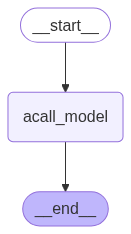

In [2]:
## Visualize graph
from IPython.display import Image, display
display(Image(basic_langgraph_agent.get_graph().draw_mermaid_png()))


In [5]:
# --------------------------- Minimal usage ----------------------------------
# Example:
from vector_databases import get_vec_client_timescale
from memory import get_postgres_connection_string

# # create timescale_db_vec_client (async version)
# vec_client = get_vec_client_timescale(get_postgres_connection_string())


config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# Non-streaming:
state = await basic_langgraph_agent.ainvoke(
    {"messages": "hi!"},
    config=config,
)
state



{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='e06356b8-edc3-431e-9ef0-c74d0c7dcbe3'),
  AIMessage(content='Hello! Welcome to our accounting firm. How can I assist you today?', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_e91a518ddb', 'service_tier': 'default'}, id='run--4d1447b9-16a2-4321-9dc9-ec600efdb754-0')]}